## Notebook for running Gene Set Enrichment Analysis (GSEA) Enrichr using gseapy
[gseapy docs](https://gseapy.readthedocs.io/en/latest/introduction.html)

In [1]:
!date

Mon Jan  9 18:22:28 UTC 2023


#### import libraries

In [2]:
import gseapy
from gseapy.enrichr import Enrichr
from pandas import DataFrame, concat, pivot
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import heatmap
import statsmodels.stats.multitest as smm

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# parameters

In [4]:
# naming
cohort = 'foundin'
dx = 'PD'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
figures_dir = f'{wrk_dir}/figures'

# input files

# output files
figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.gsea_enrichr.png'
results_file = f'{figures_dir}/{cohort}.colocalization.{dx}.gsea_enrichr.csv'

# variables
DEBUG = False
dpi_value = 100
marker_sets = ['GO_Biological_Process_2021', 
               'GO_Cellular_Component_2021', 
               'KEGG_2021_Human']
# monogenic_genes = ['PRKN', 'PARK7', 'PINK1', 'VPS35', 'RAB39B', 'GCH1', 'GBA1', 
#                    'SNCA', 'VPS13C', 'LRRK2', 'TAF1']
gene_sets = {'DAn-meta': ['CCAR2', 'P4HTM', 'NUPL2', 'RNF141', 'SH3GL2', 'KANSL1', 
                          'CTSB','STX1B', 'VAMP4', 'GRN', 'GCH1', 'CAB39L', 'LSM7', 
                          'SH2B1', 'STX4','CRLS1', 'KAT8', 'NMD3', 'SNCA', 'JAM3', 
                          'KLHL7', 'TUFM', 'CLCN3','COA3', 'CAMK2D', 'CHRNB1', 
                          'MAEA', 'LGALS3', 'SLC25A39', 'CERS6'], 
             'Bulk-meta': ['CCAR2', 'BIN3', 'NUPL2', 'CTSB', 'KANSL1', 'NCKIPSD',
                           'WDR6', 'RNF141', 'VAMP4', 'CHRNB1', 'ZNF668', 'RAB29', 
                           'KLHL7', 'NUCKS1', 'LGALS3', 'LSM7', 'STK39', 'SULT1A1',
                           'FBRSL1', 'CLCN3', 'CAB39L', 'POLR2A', 'MED13', 
                           'PSMC3IP', 'GPNMB', 'ZBTB4', 'SLC25A21-AS1', 'AMPD3',
                           'ATP6V0A1', 'CRLS1', 'PGS1', 'ARIH2OS', 'STX4'], 
             'da65_PDUI': ['lnc-RPRML-3', 'CLCN3:chr4:169719907-169720545', 
                           'CTSB', 'CCAR2', 'KAT8', 'CLCN3:chr4:169719907-169720278', 
                           'lnc-LINC02210-CRHR1-6', 'CLIP1', 'ZNF10', 'B3GALNT1', 
                           'STAT3', 'CLCN3:chr4:169719907-169723673', 'STARD7', 
                           'CLCN3:chr4:169719907-169723187', 'TAPT1', 
                           'CLCN3:chr4:169719907-169723183', 'VAMP4', 'AC026786.1', 
                           'SEC22A', 'MDC1:chr6:30713940-30714183', 'MBNL1', 
                           'SAT2', 'KANSL1'], 
             'Bryois-ExN': ['CCAR2', 'BIN3', 'LINC01630', 'ARL17B', 'WDR6', 
                            'LRRC37A2', 'SLC25A21', 'KANSL1', 'USO1', 'SPTSSB', 
                            'LINC02210-CRHR1', 'AC092835.1', 'SH3GL2', 'LSM7', 
                            'SH2B1', 'NCKIPSD', 'TUFM', 'GPRC5B', 'RHOA', 'PGS1', 
                            'RNF40', 'IGSF9B', 'ABHD17A', 'RAB29', 'CTSB', 'ISCA2', 
                            'MAPK1IP1L', 'DALRD3', 'TMEM271', 'UBAP1', 'SLC25A37', 
                            'ITGA8', 'CLCN3', 'AC008014.1', 'AC138904.3', 'PRSS3'], 
             'Bryois-InN': ['LRRC37A2', 'CCAR2', 'KANSL1', 'LINC02210-CRHR1', 
                            'BIN3', 'SH2B1', 'TUFM', 'NUPL2', 'CHFR', 'ZNF26', 
                            'ARL17B', 'PGS1', 'CREG2', 'PAM', 'UBAP2', 'MPP2', 
                            'USP19', 'SFXN2', 'HIRIP3', 'WDR6', 'ZSCAN12', 'COQ7', 
                            'PLEKHM1', 'SEPT11', 'ZKSCAN8', 'ZNF141', 'MIPOL1', 
                            'RNF40', 'TLK2', 'SH3GL2', 'RAB3GAP1'], 
             'Bryois-Micro': ['LINC02210-CRHR1', 'TMEM163', 'GPNMB', 'LRRC37A2', 
                              'P2RY12', 'MED12L', 'DNM3', 'VAMP4', 'MED13', 'ZCCHC8', 
                              'LRRK2', 'FGF20', 'RILPL2', 'NUPL2', 'KANSL1', 
                              'TNFRSF10A', 'MLX', 'PGS1', 'AC011586.2'], 
             'Bryois-Astro': ['LINC02210-CRHR1', 'CD38', 'BIN3', 'MAPT', 
                              'LRRC37A2', 'PPIP5K2', 'P4HTM', 'PGS1', 'CCAR2', 
                              'ARL17B', 'AC026471.4', 'LSM7', 'LINC00472', 'CAB39L', 
                              'SLC41A1', 'NUPL2', 'GBF1', 'KCNIP3', 'BCL7C', 'UVSSA', 
                              'NCKIPSD', 'VAMP4', 'PHF11', 'ZKSCAN8'], 
             'Bryois-Oligo': ['LINC02210-CRHR1', 'BIN3', 'STX4', 'TOX3', 'PGS1', 
                              'VAMP4', 'WDR6', 'UBAP1', 'NUPL2', 'FYN', 'LRRC37A2', 
                              'PPIP5K2', 'AC092835.1', 'NCKIPSD', 'MIPOL1', 'PLEKHM1', 
                              'MAPK1IP1L', 'LSM7', 'MRPS18B', 'NFIC', 'CAVIN1', 
                              'TIMM13', 'ARIH2', 'CDADC1']}

### check the enrichments

In [5]:
if DEBUG:
    gene_set_names = gseapy.get_library_name(organism='Human')
    print(gene_set_names)

In [6]:
def find_enrichment(name: str, genes: list, sets,
                    verbose: bool=False) -> DataFrame:
    enr_res = gseapy.enrichr(gene_list=genes,
                             organism='Human',
                             gene_sets=sets,
                             cutoff=0.5)
    enr_res.results['modality'] = name    
    if verbose:
        print(f'full {sets} results shape{enr_res.results.shape}')        
        sig = enr_res.results.loc[enr_res.results['Adjusted P-value'] <= 0.05]
        print(f'significant {sets} results shape{sig.shape}')
        display(sig)
    return enr_res.results

# compute B&H FDR for given p-values
def compute_fdr(pvalues):
    bh_adj = smm.fdrcorrection(pvalues)
    return bh_adj[1]

In [7]:
for gene_set in marker_sets:
    print(gene_set)

GO_Biological_Process_2021
GO_Cellular_Component_2021
KEGG_2021_Human


In [8]:
results = []
for modality, gene_list in gene_sets.items():
    print(f'\n########### {modality} ###########')
    # gene_list = list(set(gene_list) | set(monogenic_genes))
    for gene_set in marker_sets:
        print(f'\n+++++++++++ {gene_set} +++++++++++')
        results.append(find_enrichment(modality, gene_list, gene_set, verbose=False))


########### DAn-meta ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bulk-meta ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### da65_PDUI ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-ExN ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-InN ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-Micro ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

++++++++

### convert full enrichment results into combined data frame

In [9]:
results_df = concat(results)
print(f'full results shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(5))

full results shape (3325, 11)


### compute B&H FDR over combined enrichments

In [10]:
# apply B&H FDR corrections to results
results_df['bh_fdr'] = compute_fdr(results_df['P-value'].fillna(1))
print(f'updated shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(10))

updated shape (3325, 12)


### save the results

In [11]:
results_df.to_csv(results_file)

### how many are statistically significant

In [12]:
print(results_df.loc[results_df.bh_fdr <= 0.05].shape)
display(results_df.loc[results_df.bh_fdr <= 0.05].sort_values('Odds Ratio', ascending=False).head())

(27, 12)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
0,GO_Biological_Process_2021,dopamine biosynthetic process (GO:0042416),2/5,0.000022,0.008057,0,0,475.404762,5105.230681,GCH1;SNCA,DAn-meta,0.032121
0,GO_Biological_Process_2021,cardiolipin biosynthetic process (GO:0032049),2/7,0.000055,0.019154,0,0,257.574194,2525.611343,PGS1;CRLS1,Bulk-meta,0.039406
1,GO_Biological_Process_2021,phosphatidylglycerol biosynthetic process (GO:...,2/9,0.000094,0.019154,0,0,183.963134,1705.051217,PGS1;CRLS1,Bulk-meta,0.039406
2,GO_Biological_Process_2021,SNARE complex assembly (GO:0035493),2/10,0.000097,0.015815,0,0,178.232143,1646.736531,VAMP4;SNCA,DAn-meta,0.039406
0,GO_Biological_Process_2021,histone H4-K5 acetylation (GO:0043981),2/15,0.000132,0.015268,0,0,146.256410,1306.884074,KANSL1;KAT8,da65_PDUI,0.039406


### reshape the dataframe from long to wide

In [13]:
# temp_df = results_df.loc[(results_df.modality == 'DAn-meta') & 
#                          (results_df.bh_fdr <= 0.05)]
temp_df = results_df.loc[results_df.bh_fdr <= 0.05]
wcoloc_df = pivot(results_df.loc[results_df.Term.isin(temp_df.Term)], 
                  index=['Gene_set', 'Term'], 
                  columns=['modality'], values='Odds Ratio')
# set precision
wcoloc_df = wcoloc_df.round(2)
# drop rows that are all null
wcoloc_df.dropna(how='all', inplace=True)
wcoloc_df = wcoloc_df.sort_values(by=['DAn-meta'], ascending=False)
print(f'shape of wide reformated results {wcoloc_df.shape}')
if DEBUG:
    display(wcoloc_df)

shape of wide reformated results (24, 8)


### visualize the reformated data as a heatmap

13


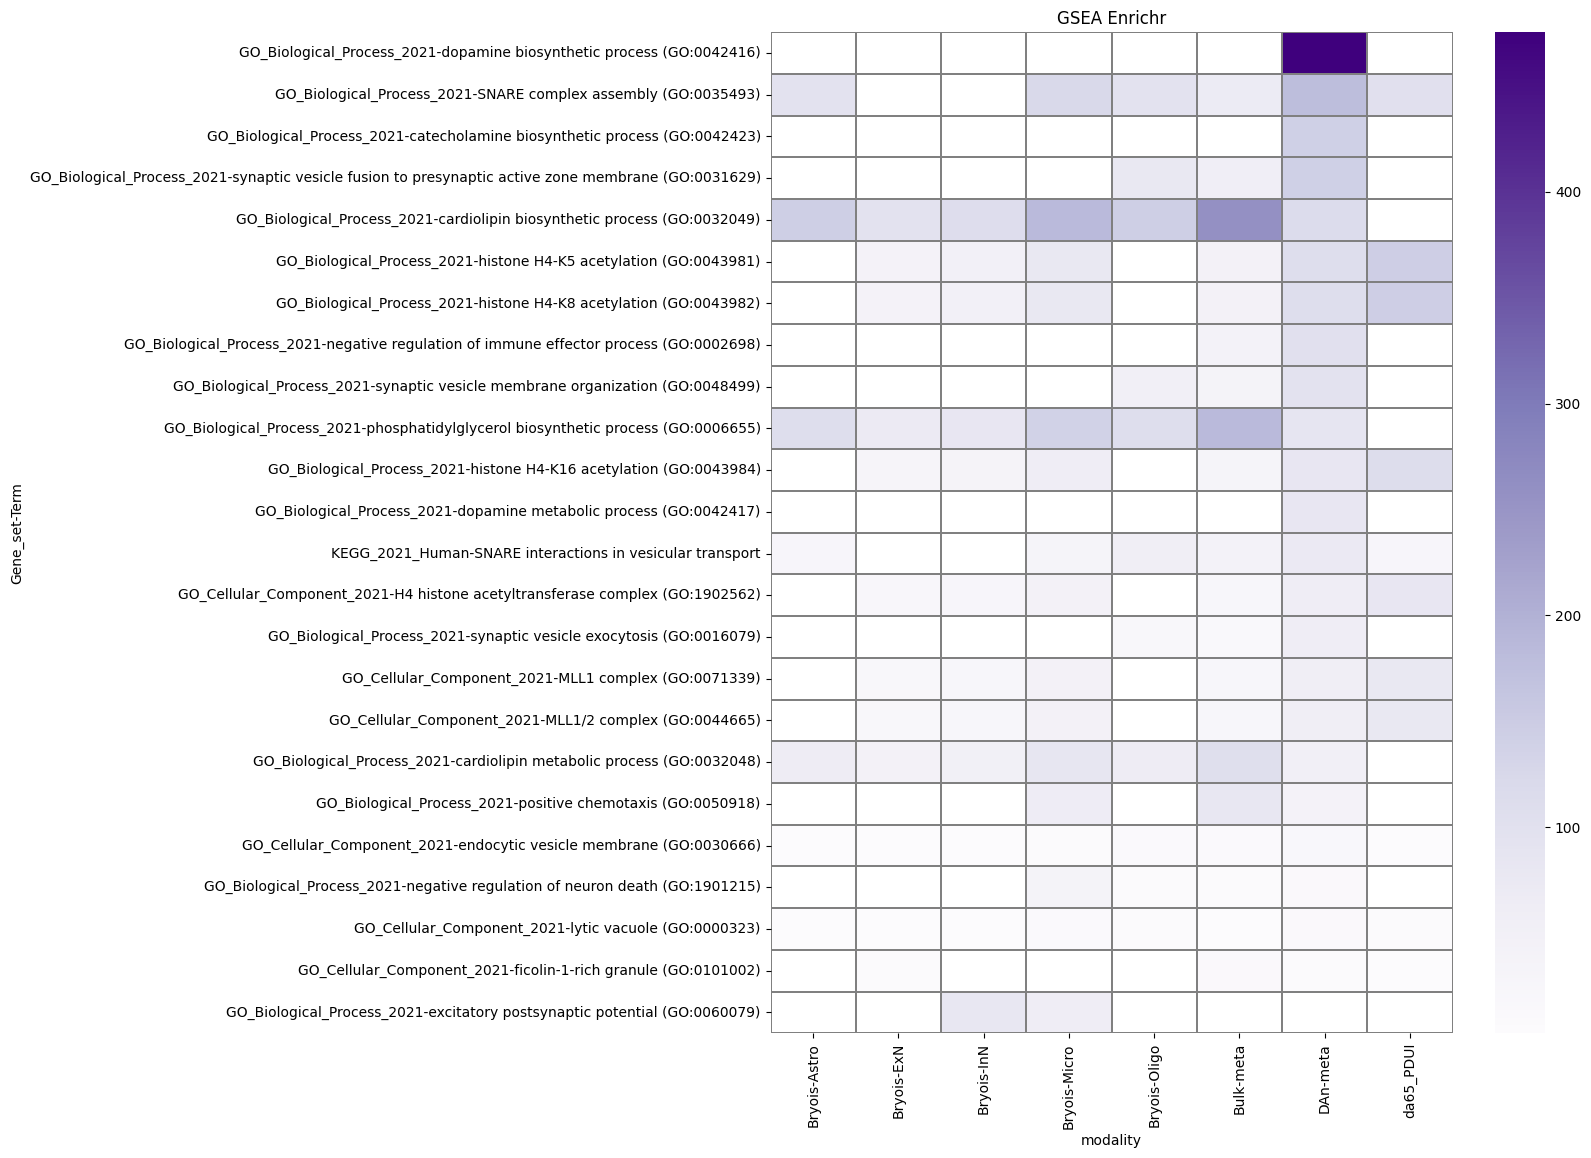

In [14]:

if wcoloc_df.shape[0] > 9:
    height = 9+ceil(wcoloc_df.shape[0]/6)
else:
    height = 9
print(height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': 50}):
    plt.style.use('seaborn-bright')    
    heatmap(wcoloc_df, linecolor='grey', linewidths=0.05, cmap='Purples')    
    plt.title('GSEA Enrichr')
    # plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
    #             transparent=True, pad_inches=1)
    plt.show()

### visualize as clustered heatmap

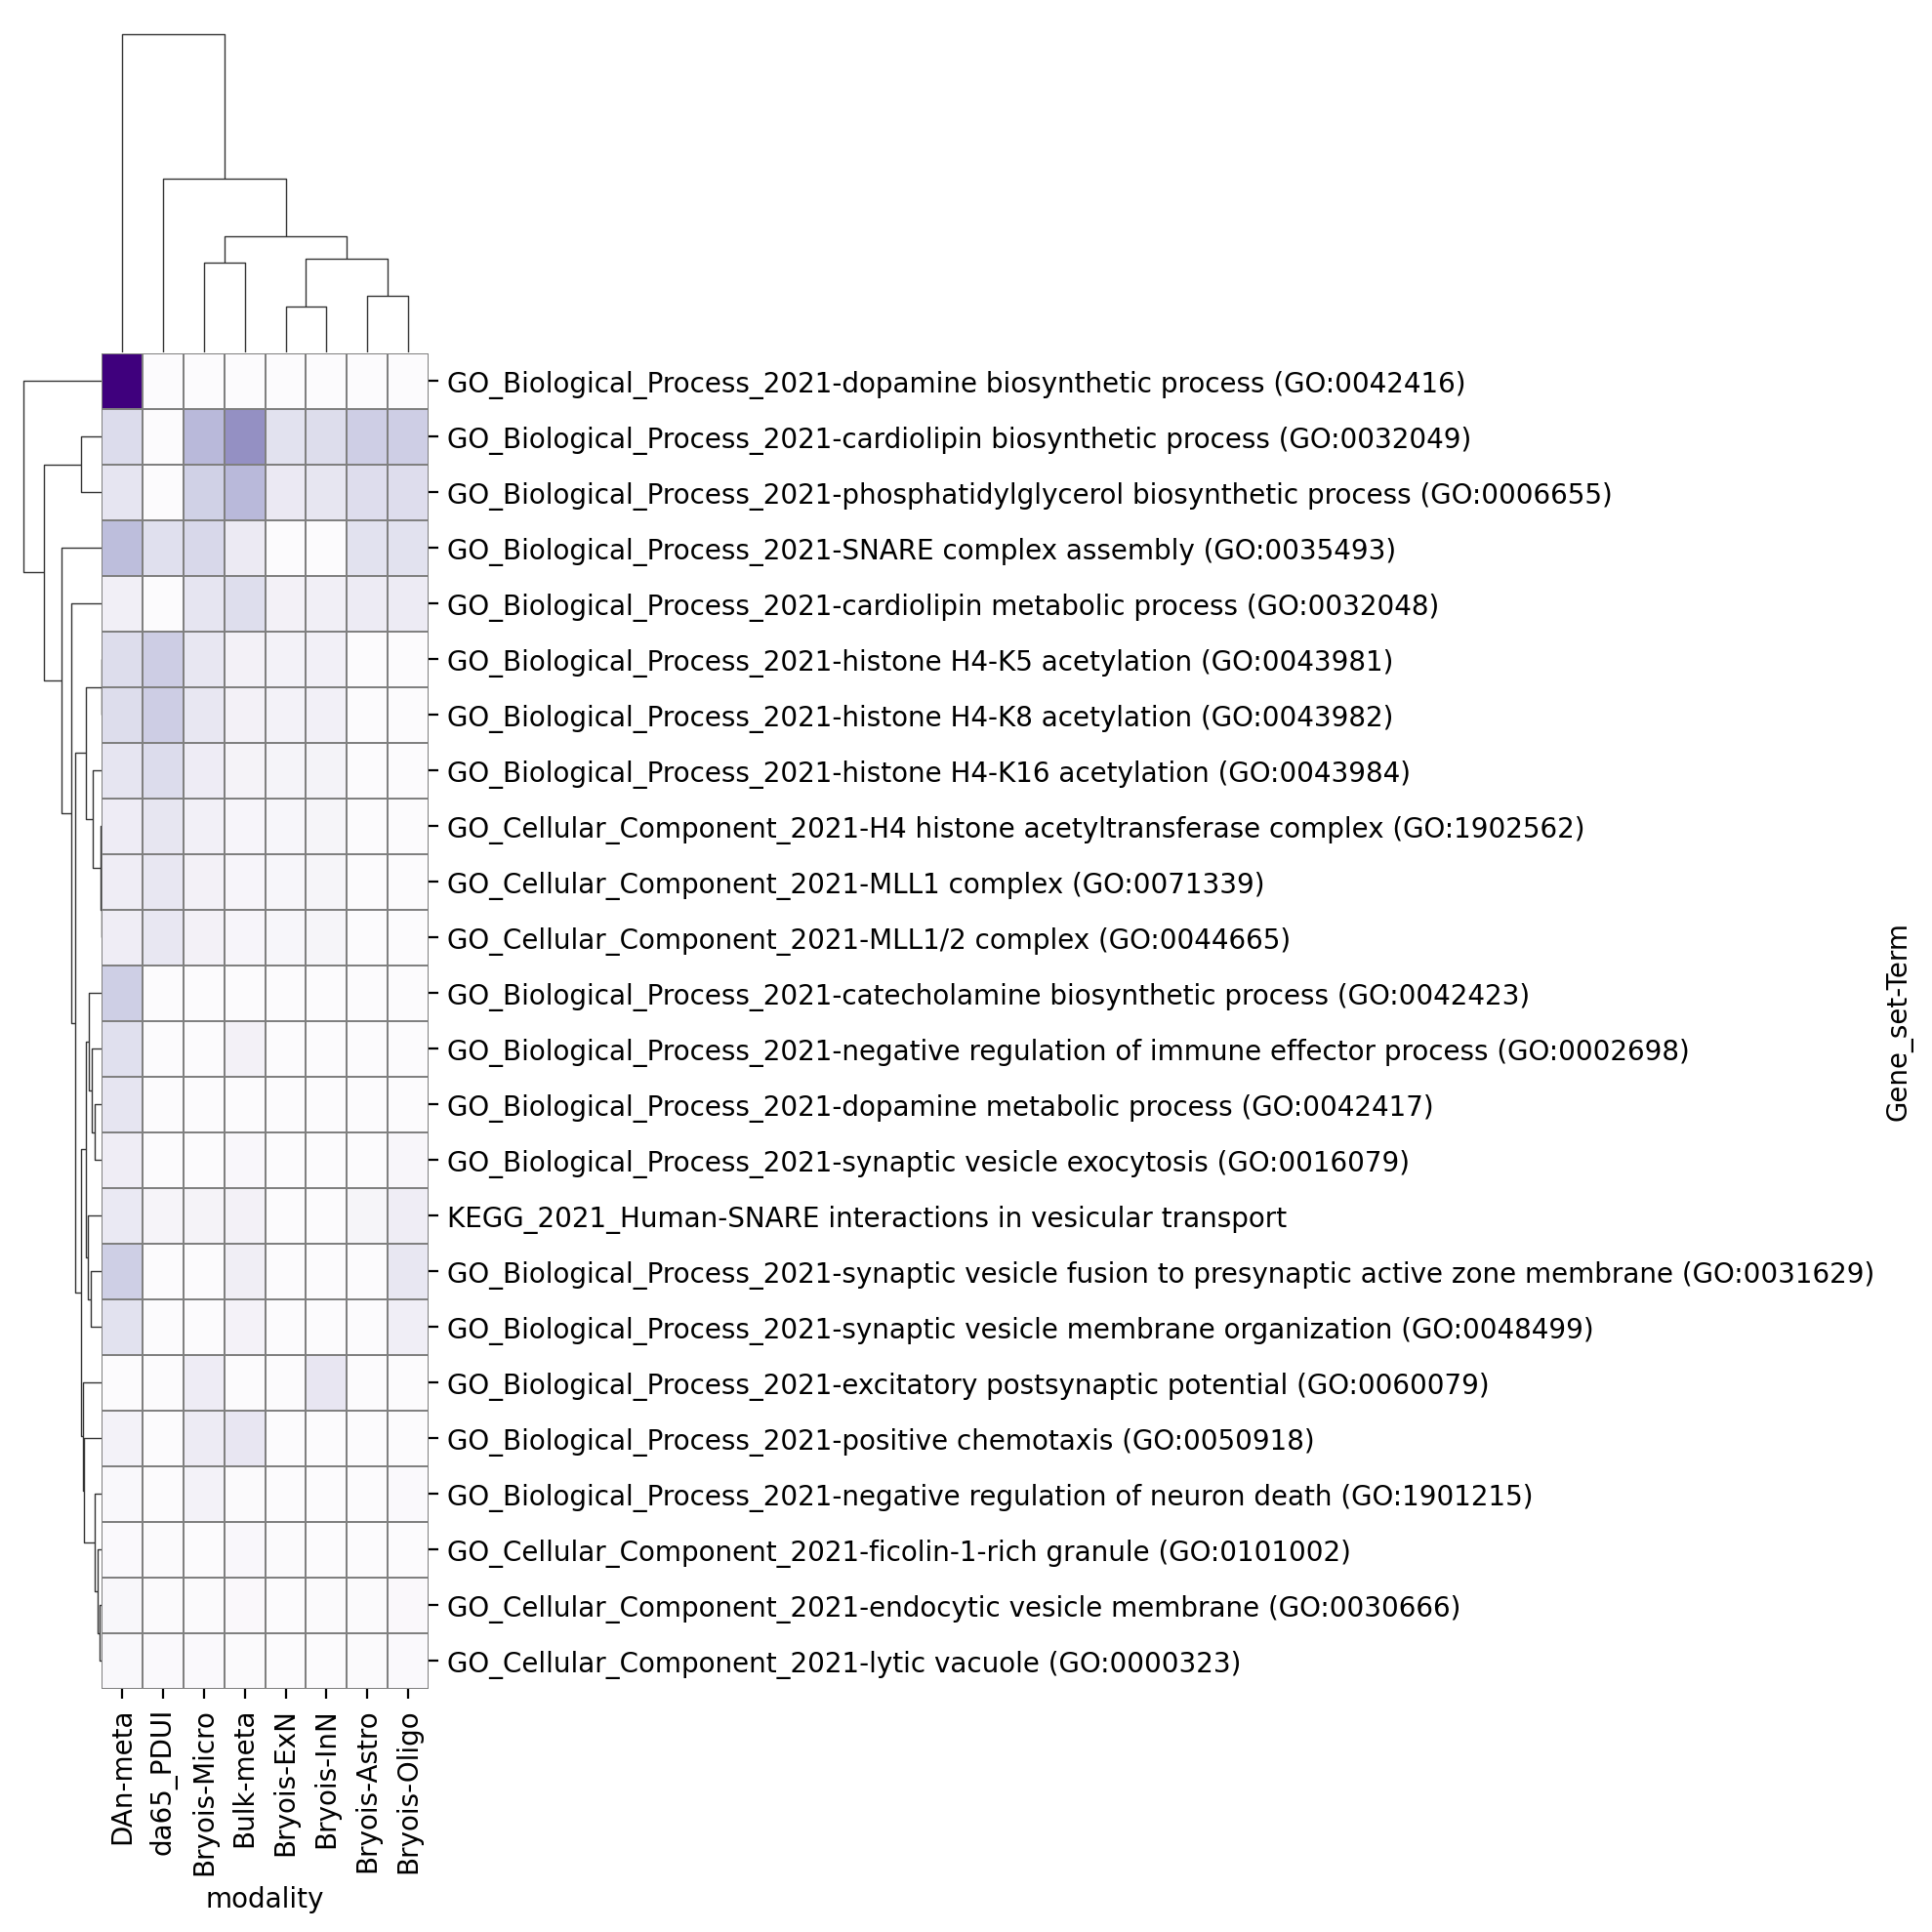

In [17]:
from seaborn import clustermap

# fill the missing
wcoloc_df = wcoloc_df.fillna(0)

with rc_context({'figure.figsize': (11, height), 'figure.dpi': 100}):
    plt.style.use('seaborn-bright')    
    # clustermap(wcoloc_df, cmap='Purples', cbar_pos=(0.75, 0.9, 0.05, 0.18))
    clustermap(wcoloc_df, cmap='Purples', cbar_pos=None, linecolor='grey', linewidths=0.05)        
    # plt.title('GSEA Enrichr')
    plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
                transparent=True, pad_inches=1)
    plt.show()

In [16]:
!date

Mon Jan  9 18:23:58 UTC 2023
